In [9]:
import pandas as pd
import numpy as np

In [10]:
df= pd.read_csv('marinetraffic_data.csv')
df.shape

(198, 21)

In [11]:
df.head()

,LAT,LON,SPEED,COURSE,HEADING,ELAPSED,DESTINATION,FLAG,LENGTH,SHIPNAME,...,SHIP_ID,WIDTH,L_FORE,W_LEFT,DWT,GT_SHIPTYPE,ROT,TYPE_IMG,TYPE_NAME,STATUS_NAME
0,2.922643,9.801392,1.0,NaN,NaN,9,NaN,CM,362.0,KOME KRIBI 1,...,746776,60.0,0.0,0.0,357106.0,56.0,NaN,NaN,NaN,NaN
1,3.573383,7.393193,0.0,173.0,23.0,75,NaN,NG,320.0,USAN FPSO,...,762843,61.0,291.0,34.0,353200.0,56.0,0.0,NaN,NaN,NaN
2,3.050263,6.697315,1.0,230.0,NaN,345,NaN,NaN,NaN,[SAT-AIS],...,TVRNMU16WXpNVE0xTXpZek1UTTFNdz09LXpwem52elQwTW...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Tanker,At Anchor
3,4.003217,7.783553,1.0,357.0,166.0,12,FSO,NG,298.0,FSO UNITY,...,762499,62.0,50.0,32.0,341097.0,56.0,0.0,NaN,NaN,NaN
4,3.462713,5.560518,0.0,231.0,NaN,15,NaN,NG,319.0,AGBAMI FPSO,...,762501,58.0,20.0,49.0,337858.0,56.0,NaN,NaN,NaN,NaN


In [12]:
df.columns

Index(['LAT', 'LON', 'SPEED', 'COURSE', 'HEADING', 'ELAPSED', 'DESTINATION',
       'FLAG', 'LENGTH', 'SHIPNAME', 'SHIPTYPE', 'SHIP_ID', 'WIDTH', 'L_FORE',
       'W_LEFT', 'DWT', 'GT_SHIPTYPE', 'ROT', 'TYPE_IMG', 'TYPE_NAME',
       'STATUS_NAME'],
      dtype='object')

In [13]:
df.isnull().sum()

,0
LAT,0
LON,0
SPEED,3
COURSE,8
HEADING,130
ELAPSED,0
DESTINATION,106
FLAG,91
LENGTH,91
SHIPNAME,0


In [14]:
# drop irrelevant cols
columns_to_drop = [
    'DESTINATION', 'L_FORE', 'W_LEFT',
    'GT_SHIPTYPE', 'TYPE_IMG', 'TYPE_NAME'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# drop rows
critical_cols = ['LAT', 'LON', 'SPEED', 'COURSE']
df.dropna(subset=critical_cols, inplace=True)

# If heading is useful, fill with 0, otherwise drop
if 'HEADING' in df.columns:
    df['HEADING'] = df['HEADING'].fillna(0)

# mean imputation for l,w cols
for col in ['LENGTH', 'WIDTH']:
    if col in df.columns:
        df[col] = df.groupby('SHIPTYPE')[col].transform(lambda x: x.fillna(x.mean()))

# imputation of dwt(deadweight tonnage col) and categorical cols

cat_fill = {
    'FLAG': 'XX',
    'STATUS_NAME': 'unknown'
}
for col, fill_value in cat_fill.items():
    if col in df.columns:
        df[col] = df[col].fillna(fill_value)

if 'DWT' in df.columns:
    df['DWT'] = df.groupby('SHIPTYPE')['DWT'].transform(lambda x: x.fillna(x.median()))

final_essentials = ['LENGTH', 'WIDTH', 'DWT']
df.dropna(subset=[col for col in final_essentials if col in df.columns], inplace=True)

df.reset_index(drop=True, inplace=True)

float_cols = ['LAT', 'LON', 'SPEED', 'COURSE', 'HEADING', 'LENGTH', 'WIDTH', 'DWT']
for col in float_cols:
    if col in df.columns:
        df[col] = df[col].astype(np.float32)

df.to_csv("cleaned_vessel_data.csv", index=False)
print(f"Cleaning complete. Final shape: {df.shape}")


Cleaning complete. Final shape: (184, 15)


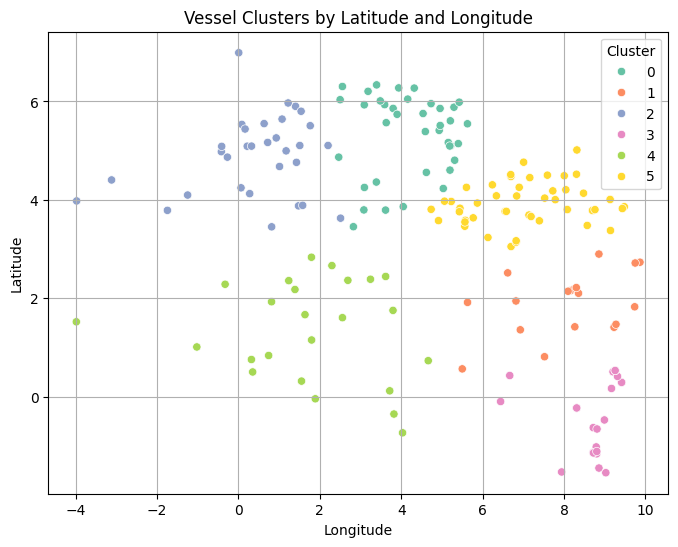

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cleaned_vessel_data.csv")

df_location = df[['LAT', 'LON']].dropna()

# Normalize coordinates for kmeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_location)

kmeans = KMeans(n_clusters=6, random_state=42, n_init='auto')
df_location['CLUSTER'] = kmeans.fit_predict(X_scaled)

df['POSITION_CLUSTER'] = df_location['CLUSTER']

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_location, x='LON', y='LAT', hue='CLUSTER', palette='Set2')
plt.title("Vessel Clusters by Latitude and Longitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

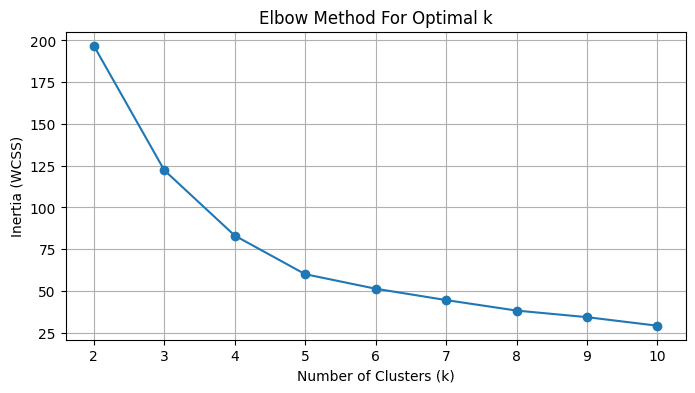

In [32]:
inertias = []
range_n = range(2, 11)

for k in range_n:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range_n, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method For Optimal k")
plt.grid(True)
plt.show()


In [31]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Inertia (WCSS):", kmeans.inertia_)
print("Silhouette Score:", silhouette_score(X_scaled, df_location['CLUSTER']))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, df_location['CLUSTER']))

Inertia (WCSS): 51.31686822877501
Silhouette Score: 0.42368757134292284
Davies-Bouldin Index: 0.7711558138494321


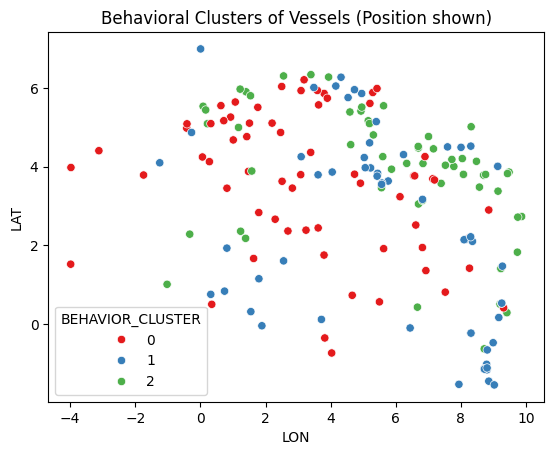

In [18]:
behavioral_features = ['SPEED', 'COURSE', 'HEADING', 'LENGTH', 'WIDTH', 'SHIPTYPE']

# Use same pipeline but exclude LAT and LON
X_behavior = df[behavioral_features].copy()

# Build same preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['SPEED', 'COURSE', 'HEADING', 'LENGTH', 'WIDTH']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['SHIPTYPE'])
    ]
)

kmeans_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('cluster', KMeans(n_clusters=3, random_state=42, n_init='auto'))
])

kmeans_pipeline.fit(X_behavior)
df['BEHAVIOR_CLUSTER'] = kmeans_pipeline.named_steps['cluster'].labels_

# Plot again by LAT/LON colored by BEHAVIOR_CLUSTER
sns.scatterplot(data=df, x='LON', y='LAT', hue='BEHAVIOR_CLUSTER', palette='Set1')
plt.title("Behavioral Clusters of Vessels (Position shown)")
plt.show()


In [22]:
def detect_speed_anomalies_iqr(df):
    df['SPEED'] = pd.to_numeric(df['SPEED'], errors='coerce')
    df['SHIPTYPE'] = df['SHIPTYPE'].astype(str)

    anomalies = pd.DataFrame()

    for ship_type, group in df.groupby('SHIPTYPE'):
        Q1 = group['SPEED'].quantile(0.25)
        Q3 = group['SPEED'].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = group[(group['SPEED'] < lower) | (group['SPEED'] > upper)]
        anomalies = pd.concat([anomalies, outliers])

    return anomalies

iqr_anomalies = detect_speed_anomalies_iqr(df)
print(iqr_anomalies[['SHIP_ID', 'SPEED', 'SHIPTYPE']])


Empty DataFrame
Columns: [SHIP_ID, SPEED, SHIPTYPE]
Index: []


In [23]:
def detect_unusual_speeds(df, z_thresh=1.0): # hit-and-trial for now
    df['SPEED'] = pd.to_numeric(df['SPEED'], errors='coerce')
    df['SHIPTYPE'] = df['SHIPTYPE'].astype(str)

    anomalies = pd.DataFrame()

    for ship_type, group in df.groupby('SHIPTYPE'):
        mean_speed = group['SPEED'].mean()
        std_speed = group['SPEED'].std()
        if pd.isna(std_speed) or std_speed == 0:
            continue
        group['SPEED_Z'] = (group['SPEED'] - mean_speed) / std_speed
        outliers = group[np.abs(group['SPEED_Z']) > z_thresh]
        anomalies = pd.concat([anomalies, outliers])

    return anomalies

speed_anomalies = detect_unusual_speeds(df)
print("Unusual Speed Anomalies:")
print(speed_anomalies[['SHIP_ID', 'SPEED', 'SHIPTYPE']])


Unusual Speed Anomalies:
                                               SHIP_ID  SPEED SHIPTYPE
166  T1RZM09UZ3dPVFkzT1Rnd09UWTNPUT09LUFsUkNlNU95ck...   12.0        2
167  TVRjek1ETXpNVGN6TURNek1UY3pNQT09LUMrcXFTMWIrMF...    0.0        2
168                                            7137583  121.0        2
169  TkRneE9ERTRORGd4T0RFNE5EZ3hPQT09LW1maWlYTmNXTW...  111.0        2
115                                            7255353    0.0        3
..                                                 ...    ...      ...
109  TVRJM016QTNNVEkzTXpBM01USTNNdz09LU8zeFVwOHBYTm...  130.0        8
117  TmpFME1qTTROakUwTWpNNE5qRTBNZz09LUtTQ3UzdC9RUm...  118.0        8
119  TmpjMU1USTFOamMxTVRJMU5qYzFNUT09LWZaREZsVlV6d0...  123.0        8
122                                            6573851  126.0        8
123  T1RZd016ZzNPVFl3TXpnM09UWXdNdz09LVFtcWFjS0lXTH...  116.0        8

[67 rows x 3 columns]


In [24]:
def detect_course_drift(df, threshold=45):
    df['HEADING'] = pd.to_numeric(df['HEADING'], errors='coerce')
    df['COURSE'] = pd.to_numeric(df['COURSE'], errors='coerce')
    df['HEADING_COURSE_DIFF'] = np.abs(df['HEADING'] - df['COURSE'])

    # circularity
    df['HEADING_COURSE_DIFF'] = df['HEADING_COURSE_DIFF'].apply(lambda x: min(x, 360 - x))

    drift_anomalies = df[df['HEADING_COURSE_DIFF'] > threshold]
    return drift_anomalies

drift_anomalies = detect_course_drift(df)
print("Course Drift Anomalies:")
print(drift_anomalies[['SHIP_ID', 'HEADING', 'COURSE', 'HEADING_COURSE_DIFF']])


Course Drift Anomalies:
                                               SHIP_ID  HEADING  COURSE  \
0                                               762843     23.0   173.0   
1    TVRNMU16WXpNVE0xTXpZek1UTTFNdz09LXpwem52elQwTW...      0.0   230.0   
2                                               762499    166.0   357.0   
3                                               762501      0.0   231.0   
5    TnpNM016UTBOek0zTXpRME56TTNNdz09LStQbjFpSU1wV2...      0.0   162.0   
..                                                 ...      ...     ...   
177  TmpNd09UZzROak13T1RnNE5qTXdPUT09LWwxOENFSDZCQX...      0.0   129.0   
178                                            7698857    232.0   326.0   
179                                            7190392      0.0   228.0   
180                                            5050716      0.0   250.0   
181  TXpBNE1qZzVNekE0TWpnNU16QTRNZz09LXpvMjNZRnQwWk...      0.0   294.0   

     HEADING_COURSE_DIFF  
0                  150.0  
1                  13

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def detect_suspicious_stops(df):
    df_stopped = df[pd.to_numeric(df['SPEED'], errors='coerce') < 0.5].copy()
    coords = df_stopped[['LAT', 'LON']].dropna()

    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    dbscan = DBSCAN(eps=0.5, min_samples=5) # used for irregular clutering shape
    labels = dbscan.fit_predict(coords_scaled)

    df_stopped['ISOLATED'] = (labels == -1)
    suspicious_stops = df_stopped[df_stopped['ISOLATED']]

    return suspicious_stops

stop_anomalies = detect_suspicious_stops(df)
print("Suspicious Stops Detected:")
print(stop_anomalies[['SHIP_ID', 'LAT', 'LON', 'SPEED']])


Suspicious Stops Detected:
                                               SHIP_ID       LAT       LON  \
14   TXpBM05UQXlNekEzTlRBeU16QTNOUT09LXhEbmN6REZjdF...  5.411667  4.931667   
15                                              416868  5.533400  0.082700   
32   T1RJNU56azJPVEk1TnprMk9USTVOdz09LU85TXk2d0xaa2...  5.387950  4.591440   
44                                              312710  6.336747  3.394288   
45                                              375400  4.995422  1.170858   
55   Tnpjd05UWTVOemN3TlRZNU56Y3dOUT09LWRwYjJ5Uk51SW...  5.511183  4.956700   
58                                              731634  6.304047  2.554183   
149  T0RVek5USXhPRFV6TlRJeE9EVXpOUT09LTdJZWFlODFab3...  5.857625  4.953640   
167  TVRjek1ETXpNVGN6TURNek1UY3pNQT09LUMrcXFTMWIrMF...  0.835000  0.741667   
170                                            9664620  6.990507  0.006933   
178                                            7698857 -1.116155  8.804031   

     SPEED  
14     0.0  
15     0.0